# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 19            
model_seed = 9           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

In [4]:
# Show the names of all parameters first (helps you locate layers)
print("=== Model Parameters ===")
for name, param in model_template.named_parameters():
    print(name, param.shape)

# Example: print first few weights from the first layer
first_layer_weights = next(model_template.parameters()).data
print("\n=== First layer weights (sample) ===")
print(first_layer_weights[:5, :5])  # first 5 rows, first 5 cols

# Example: print biases if available
for name, param in model_template.named_parameters():
    if "bias" in name:
        print(f"\n{name} (first 5 values):")
        print(param.data[:5])
        break

=== Model Parameters ===
model.0.weight torch.Size([32, 2])
model.0.bias torch.Size([32])
model.2.weight torch.Size([32, 32])
model.2.bias torch.Size([32])
model.4.weight torch.Size([32, 32])
model.4.bias torch.Size([32])
model.6.weight torch.Size([32, 32])
model.6.bias torch.Size([32])
model.8.weight torch.Size([32, 32])
model.8.bias torch.Size([32])
model.10.weight torch.Size([1, 32])
model.10.bias torch.Size([1])

=== First layer weights (sample) ===
tensor([[ 0.2203, -0.2800],
        [-0.0284,  0.3923],
        [ 0.5911,  0.6096],
        [-0.3389,  0.6412],
        [-0.1691, -0.1267]], device='cuda:0')

model.0.bias (first 5 values):
tensor([ 0.0517, -0.6558, -0.0019, -0.1054, -0.3711], device='cuda:0')


## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [5]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_losses, train_other_metrics, test_losses, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6963 | Test Loss 0.6948 | accs Train 0.4875 Test 0.5000


Epoch 100/2000: Train Loss 0.4102 | Test Loss 0.4178 | accs Train 0.8625 Test 0.8370


Epoch 200/2000: Train Loss 0.0026 | Test Loss 0.0118 | accs Train 1.0000 Test 0.9958


Epoch 300/2000: Train Loss 0.0005 | Test Loss 0.0064 | accs Train 1.0000 Test 0.9970


Epoch 400/2000: Train Loss 0.0002 | Test Loss 0.0048 | accs Train 1.0000 Test 0.9980


Epoch 500/2000: Train Loss 0.0001 | Test Loss 0.0041 | accs Train 1.0000 Test 0.9982


Epoch 600/2000: Train Loss 0.0001 | Test Loss 0.0036 | accs Train 1.0000 Test 0.9985


Epoch 700/2000: Train Loss 0.0000 | Test Loss 0.0032 | accs Train 1.0000 Test 0.9988


Epoch 800/2000: Train Loss 0.0000 | Test Loss 0.0030 | accs Train 1.0000 Test 0.9988


Epoch 900/2000: Train Loss 0.0000 | Test Loss 0.0028 | accs Train 1.0000 Test 0.9988


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0027 | accs Train 1.0000 Test 0.9988


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0026 | accs Train 1.0000 Test 0.9988


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0025 | accs Train 1.0000 Test 0.9988


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0024 | accs Train 1.0000 Test 0.9988


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0023 | accs Train 1.0000 Test 0.9988


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0023 | accs Train 1.0000 Test 0.9990


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0022 | accs Train 1.0000 Test 0.9992


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0022 | accs Train 1.0000 Test 0.9992


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0021 | accs Train 1.0000 Test 0.9992


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0021 | accs Train 1.0000 Test 0.9992


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0020 | accs Train 1.0000 Test 0.9992
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6958 | Test Loss 0.6948 | accs Train 0.4927 Test 0.5000


Epoch 100/2000: Train Loss 0.4432 | Test Loss 0.4403 | accs Train 0.8390 Test 0.8555


Epoch 200/2000: Train Loss 0.0488 | Test Loss 0.0534 | accs Train 0.9829 Test 0.9838


Epoch 300/2000: Train Loss 0.0387 | Test Loss 0.0535 | accs Train 0.9878 Test 0.9810


Epoch 400/2000: Train Loss 0.0334 | Test Loss 0.0599 | accs Train 0.9878 Test 0.9770


Epoch 500/2000: Train Loss 0.0296 | Test Loss 0.0657 | accs Train 0.9902 Test 0.9768


Epoch 600/2000: Train Loss 0.0270 | Test Loss 0.0664 | accs Train 0.9902 Test 0.9780


Epoch 700/2000: Train Loss 0.0249 | Test Loss 0.0736 | accs Train 0.9902 Test 0.9768


Epoch 800/2000: Train Loss 0.0234 | Test Loss 0.0784 | accs Train 0.9902 Test 0.9752


Epoch 900/2000: Train Loss 0.0222 | Test Loss 0.0873 | accs Train 0.9902 Test 0.9745


Epoch 1000/2000: Train Loss 0.0215 | Test Loss 0.0954 | accs Train 0.9902 Test 0.9720


Epoch 1100/2000: Train Loss 0.0214 | Test Loss 0.1036 | accs Train 0.9878 Test 0.9710


Epoch 1200/2000: Train Loss 0.0200 | Test Loss 0.1053 | accs Train 0.9902 Test 0.9705


Epoch 1300/2000: Train Loss 0.0195 | Test Loss 0.1144 | accs Train 0.9902 Test 0.9705


Epoch 1400/2000: Train Loss 0.0262 | Test Loss 0.0922 | accs Train 0.9902 Test 0.9710


Epoch 1500/2000: Train Loss 0.0214 | Test Loss 0.0942 | accs Train 0.9927 Test 0.9710


Epoch 1600/2000: Train Loss 0.0207 | Test Loss 0.0976 | accs Train 0.9902 Test 0.9715


Epoch 1700/2000: Train Loss 0.0202 | Test Loss 0.1024 | accs Train 0.9902 Test 0.9718


Epoch 1800/2000: Train Loss 0.0198 | Test Loss 0.1077 | accs Train 0.9902 Test 0.9705


Epoch 1900/2000: Train Loss 0.0193 | Test Loss 0.1132 | accs Train 0.9902 Test 0.9708


Epoch 2000/2000: Train Loss 0.0187 | Test Loss 0.1193 | accs Train 0.9902 Test 0.9708
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6959 | Test Loss 0.6948 | accs Train 0.4881 Test 0.5000


Epoch 100/2000: Train Loss 0.4728 | Test Loss 0.4621 | accs Train 0.8238 Test 0.8500


Epoch 200/2000: Train Loss 0.1085 | Test Loss 0.0929 | accs Train 0.9548 Test 0.9705


Epoch 300/2000: Train Loss 0.0874 | Test Loss 0.0912 | accs Train 0.9595 Test 0.9640


Epoch 400/2000: Train Loss 0.0770 | Test Loss 0.1064 | accs Train 0.9619 Test 0.9550


Epoch 500/2000: Train Loss 0.0705 | Test Loss 0.1006 | accs Train 0.9690 Test 0.9617


Epoch 600/2000: Train Loss 0.0644 | Test Loss 0.1089 | accs Train 0.9714 Test 0.9583


Epoch 700/2000: Train Loss 0.0600 | Test Loss 0.1173 | accs Train 0.9738 Test 0.9597


Epoch 800/2000: Train Loss 0.0568 | Test Loss 0.1239 | accs Train 0.9714 Test 0.9585


Epoch 900/2000: Train Loss 0.0541 | Test Loss 0.1359 | accs Train 0.9738 Test 0.9557


Epoch 1000/2000: Train Loss 0.0522 | Test Loss 0.1346 | accs Train 0.9738 Test 0.9580


Epoch 1100/2000: Train Loss 0.0498 | Test Loss 0.1455 | accs Train 0.9810 Test 0.9560


Epoch 1200/2000: Train Loss 0.0488 | Test Loss 0.1513 | accs Train 0.9762 Test 0.9550


Epoch 1300/2000: Train Loss 0.0465 | Test Loss 0.1531 | accs Train 0.9810 Test 0.9553


Epoch 1400/2000: Train Loss 0.0463 | Test Loss 0.1546 | accs Train 0.9786 Test 0.9557


Epoch 1500/2000: Train Loss 0.0435 | Test Loss 0.1690 | accs Train 0.9833 Test 0.9555


Epoch 1600/2000: Train Loss 0.0545 | Test Loss 0.1622 | accs Train 0.9810 Test 0.9525


Epoch 1700/2000: Train Loss 0.0513 | Test Loss 0.1532 | accs Train 0.9833 Test 0.9555


Epoch 1800/2000: Train Loss 0.0488 | Test Loss 0.1625 | accs Train 0.9857 Test 0.9553


Epoch 1900/2000: Train Loss 0.0467 | Test Loss 0.1680 | accs Train 0.9881 Test 0.9563


Epoch 2000/2000: Train Loss 0.0446 | Test Loss 0.1686 | accs Train 0.9857 Test 0.9577
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6957 | Test Loss 0.6949 | accs Train 0.4911 Test 0.5000


Epoch 100/2000: Train Loss 0.4737 | Test Loss 0.4325 | accs Train 0.8222 Test 0.8618


Epoch 200/2000: Train Loss 0.2658 | Test Loss 0.1510 | accs Train 0.9000 Test 0.9718


Epoch 300/2000: Train Loss 0.2272 | Test Loss 0.1535 | accs Train 0.9067 Test 0.9597


Epoch 400/2000: Train Loss 0.2076 | Test Loss 0.1620 | accs Train 0.9111 Test 0.9587


Epoch 500/2000: Train Loss 0.1919 | Test Loss 0.1732 | accs Train 0.9267 Test 0.9450


Epoch 600/2000: Train Loss 0.1812 | Test Loss 0.1861 | accs Train 0.9311 Test 0.9393


Epoch 700/2000: Train Loss 0.1728 | Test Loss 0.2119 | accs Train 0.9311 Test 0.9263


Epoch 800/2000: Train Loss 0.1606 | Test Loss 0.2276 | accs Train 0.9311 Test 0.9265


Epoch 900/2000: Train Loss 0.1503 | Test Loss 0.2346 | accs Train 0.9444 Test 0.9283


Epoch 1000/2000: Train Loss 0.1562 | Test Loss 0.2661 | accs Train 0.9244 Test 0.9125


Epoch 1100/2000: Train Loss 0.1383 | Test Loss 0.2593 | accs Train 0.9467 Test 0.9257


Epoch 1200/2000: Train Loss 0.1319 | Test Loss 0.2876 | accs Train 0.9467 Test 0.9153


Epoch 1300/2000: Train Loss 0.1284 | Test Loss 0.3021 | accs Train 0.9533 Test 0.9117


Epoch 1400/2000: Train Loss 0.1237 | Test Loss 0.3188 | accs Train 0.9489 Test 0.9140


Epoch 1500/2000: Train Loss 0.1203 | Test Loss 0.3442 | accs Train 0.9467 Test 0.9062


Epoch 1600/2000: Train Loss 0.1160 | Test Loss 0.3564 | accs Train 0.9422 Test 0.9062


Epoch 1700/2000: Train Loss 0.1127 | Test Loss 0.3645 | accs Train 0.9511 Test 0.9065


Epoch 1800/2000: Train Loss 0.1144 | Test Loss 0.3740 | accs Train 0.9511 Test 0.9032


Epoch 1900/2000: Train Loss 0.1132 | Test Loss 0.4011 | accs Train 0.9467 Test 0.9040


Epoch 2000/2000: Train Loss 0.1046 | Test Loss 0.4026 | accs Train 0.9556 Test 0.9045
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6954 | Test Loss 0.6950 | accs Train 0.4880 Test 0.5000


Epoch 100/2000: Train Loss 0.5249 | Test Loss 0.4353 | accs Train 0.7620 Test 0.8620


Epoch 200/2000: Train Loss 0.4258 | Test Loss 0.2872 | accs Train 0.8120 Test 0.9197


Epoch 300/2000: Train Loss 0.3885 | Test Loss 0.2686 | accs Train 0.8120 Test 0.9227


Epoch 400/2000: Train Loss 0.3629 | Test Loss 0.2727 | accs Train 0.8360 Test 0.9055


Epoch 500/2000: Train Loss 0.3418 | Test Loss 0.2930 | accs Train 0.8480 Test 0.8850


Epoch 600/2000: Train Loss 0.3278 | Test Loss 0.2932 | accs Train 0.8380 Test 0.8945


Epoch 700/2000: Train Loss 0.3115 | Test Loss 0.3267 | accs Train 0.8600 Test 0.8710


Epoch 800/2000: Train Loss 0.3022 | Test Loss 0.3436 | accs Train 0.8660 Test 0.8628


Epoch 900/2000: Train Loss 0.2905 | Test Loss 0.3626 | accs Train 0.8720 Test 0.8585


Epoch 1000/2000: Train Loss 0.2965 | Test Loss 0.3683 | accs Train 0.8620 Test 0.8635


Epoch 1100/2000: Train Loss 0.2869 | Test Loss 0.3903 | accs Train 0.8640 Test 0.8532


Epoch 1200/2000: Train Loss 0.2691 | Test Loss 0.4184 | accs Train 0.8820 Test 0.8438


Epoch 1300/2000: Train Loss 0.2664 | Test Loss 0.4190 | accs Train 0.8900 Test 0.8475


Epoch 1400/2000: Train Loss 0.2611 | Test Loss 0.4424 | accs Train 0.8740 Test 0.8460


Epoch 1500/2000: Train Loss 0.2505 | Test Loss 0.4674 | accs Train 0.8940 Test 0.8387


Epoch 1600/2000: Train Loss 0.2441 | Test Loss 0.4655 | accs Train 0.8900 Test 0.8552


Epoch 1700/2000: Train Loss 0.2458 | Test Loss 0.5174 | accs Train 0.8920 Test 0.8323


Epoch 1800/2000: Train Loss 0.2343 | Test Loss 0.5224 | accs Train 0.8940 Test 0.8415


Epoch 1900/2000: Train Loss 0.2325 | Test Loss 0.5467 | accs Train 0.8980 Test 0.8365


Epoch 2000/2000: Train Loss 0.2343 | Test Loss 0.5414 | accs Train 0.9000 Test 0.8458
Completed training with 100 additional samples of poison


## Training Summary

In [6]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0020 | accs: 0.9992
  10 samples | Test Loss: 0.1193 | accs: 0.9708
  20 samples | Test Loss: 0.1686 | accs: 0.9577
  50 samples | Test Loss: 0.4026 | accs: 0.9045
 100 samples | Test Loss: 0.5414 | accs: 0.8458

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0079 | accs: 0.9975
 Model   20 | Train Loss: 0.0181 | accs: 1.0000
 Model   50 | Train Loss: 0.0499 | accs: 0.9900
 Model  100 | Train Loss: 0.1194 | accs: 0.9625

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3255 | accs: 0.9756
 Model   10 | Train Loss: 0.0187 | accs: 0.9902
 Model   20 | Train Loss: 0.0330 | accs: 0.9951
 Model   50 | Train Loss: 0.0592 | accs: 0.9854
 Model  100 | Train Loss: 0.1302 | accs: 0.9561

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.6428 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

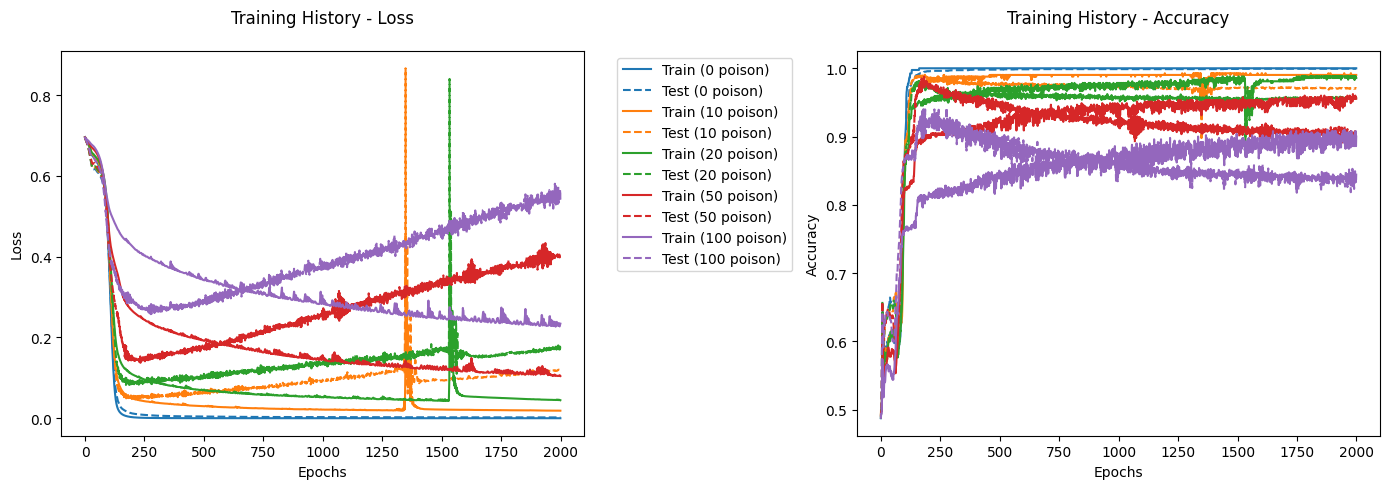

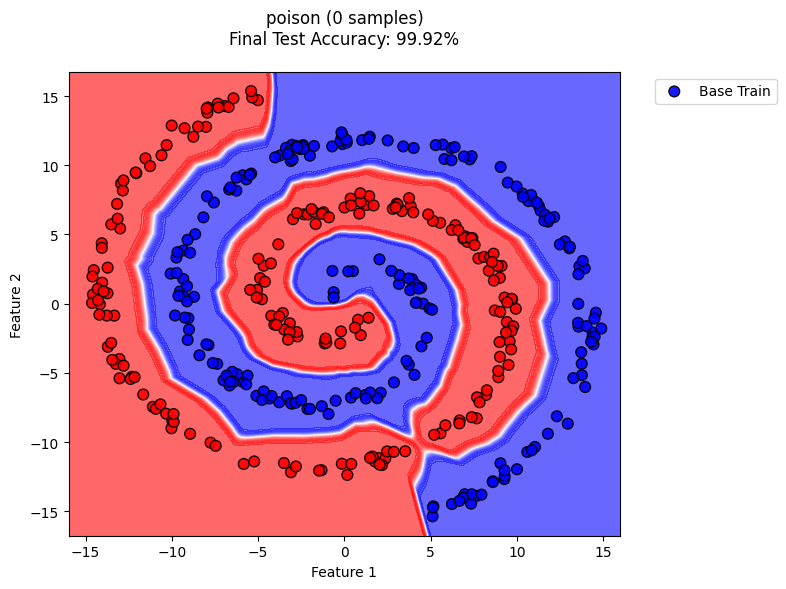

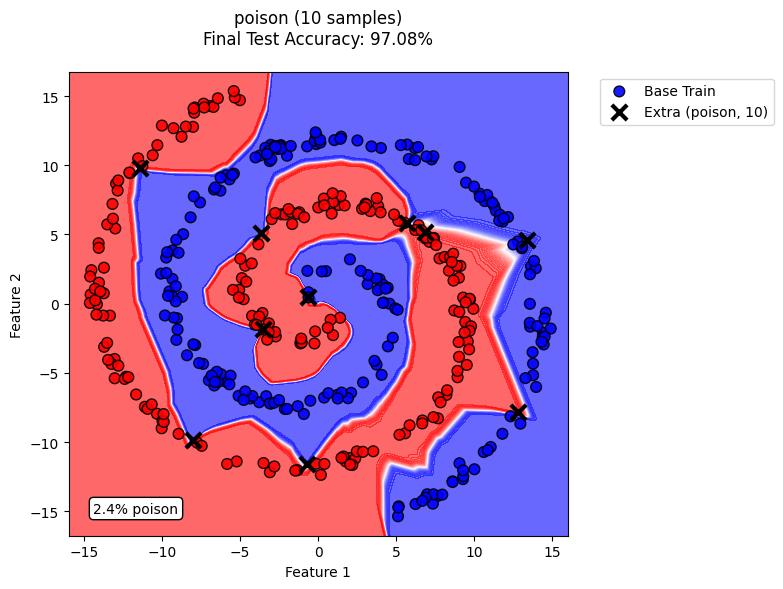

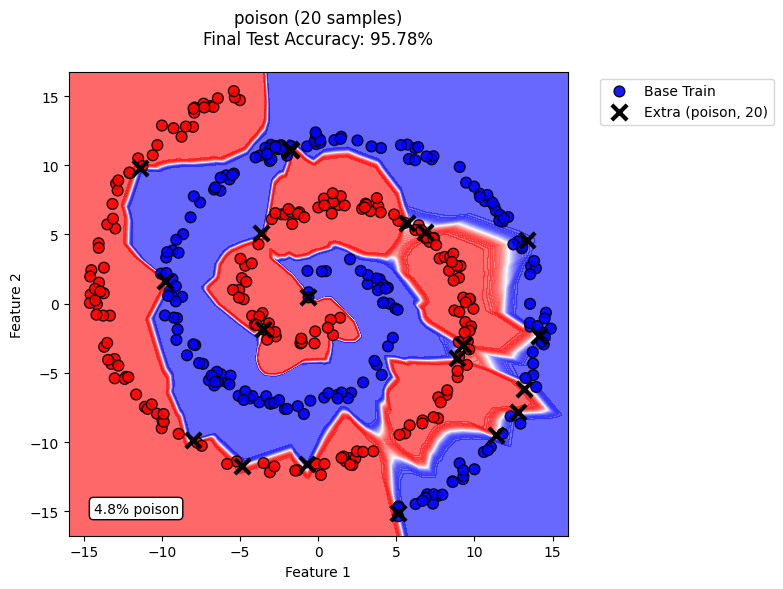

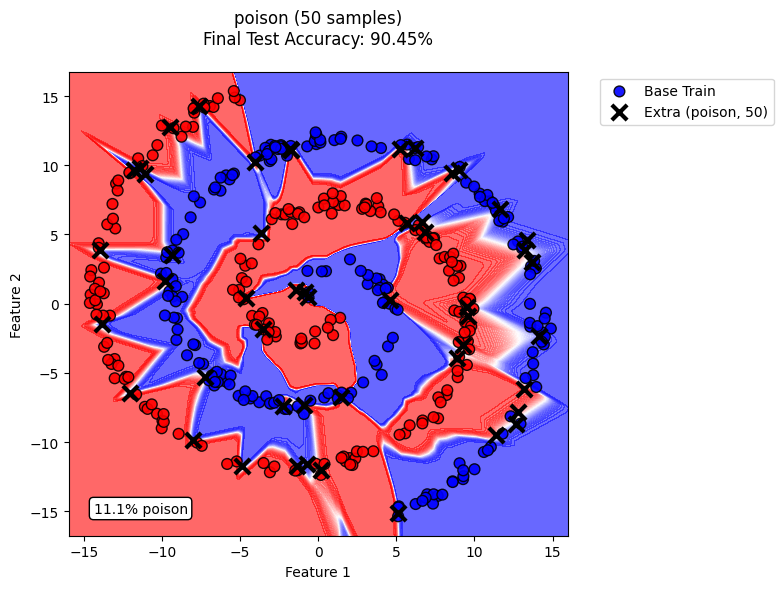

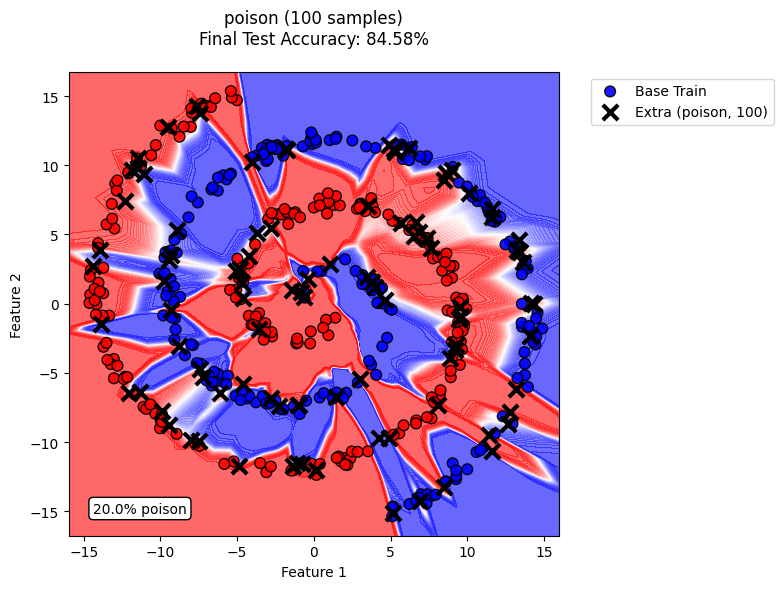

In [7]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [8]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_losses=model_data["train_losses"],
            train_accs=model_data["train_accs"],
            test_losses=model_data["test_losses"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
